## Animal Classifier (22M Parameter model)
Training an image classification model using pytorch

In [12]:
import os
from pathlib import Path

import torch, torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

print(f"Pytorch version: {torch.__version__}")

Pytorch version: 2.1.1


### SETUP

In [13]:
# GPU or CPU?
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### DATASET
Load and clean the dataset:
1. Make sure the animals dataset is downloaded into the "datasets/animals" directory
   (https://www.kaggle.com/datasets/npurav/animal-classification-dataset)
2. Add augmented images to the dataset.
3. Load the dataset then split into train and test data

In [14]:
# Get root directory
BASE_DIR = Path.cwd().resolve().parent.parent

# Path to your dataset
dataset_path = BASE_DIR / 'datasets/animals/dataset'

# Define transformations (you can customize these based on your needs)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),
])

# Create ImageFolder dataset
dataset = ImageFolder(dataset_path, transform=transform)
class_names = dataset.classes
print(f'Total number of classes: {len(class_names)}')

Total number of classes: 117


In [15]:
# Image augmentation
# Define image transformations for augmentation
augmentation_transform = transforms.Compose([
    #transforms.RandomResizedCrop(224),        # Random crop and resize
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomVerticalFlip(),          # Random vertical flip
    # transforms.RandomRotation(degrees=15),    # Random rotation (up to 15 degrees)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomGrayscale(p=0.1),        # Randomly convert to grayscale
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),  # Random perspective
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Create augmented dataset
for i in range(8):
    # Apply augmentation to the entire dataset
    augmented_dataset = ImageFolder(dataset_path, transform=augmentation_transform)
    # Combine the original and augmented datasets
    dataset = torch.utils.data.ConcatDataset([dataset, augmented_dataset])
    
print(f'Total number of images: {len(dataset)}')

Total number of images: 173025


In [16]:
# Split the dataset into training and testing sets

# Define the sizes for training, validation, and testing sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split
trainset, valset, testset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(f'Total number of training images: {len(trainset)}')
print(f'Total number of validation images: {len(valset)}')
print(f'Total number of test images: {len(testset)}')

Total number of training images: 138420
Total number of validation images: 17302
Total number of test images: 17303


In [17]:
# Create data loaders
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

Display a subset of the training images

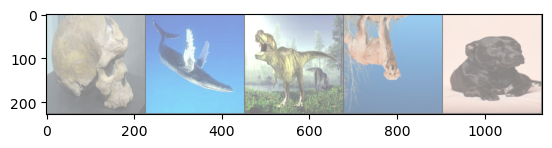

homo-sapiens megaptera-novaeangliae tyrannosaurus-rex canis-lupus-familiaris canis-lupus-familiaris
CPU times: user 850 ms, sys: 171 ms, total: 1.02 s
Wall time: 8.33 s


In [18]:
%%time

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[0:5]))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(5)))

### TRAINING STEP
Define a convolution neural network

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(16, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(6272, 3000)
        self.fc2 = nn.Linear(3000, 1000)
        self.fc3 = nn.Linear(1000, len(class_names))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)
print(f'Trainable params: {sum(p.numel() for p in net.parameters() if p.requires_grad)}')

Trainable params: 22021469


Define learning rate, loss function and optimizer

In [24]:
learning_rate = 0.005

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)

Train the network

In [25]:
%%time
epochs = 20

# Initialize an empty list to store loss values for plotting
loss_values = []
val_loss_values = []
print('Starting Training...')
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step = 200
        if i % step == step - 1:    # print after ever "step" mini-batches
            print(f'epoch({epoch + 1}/{epochs}) batch: {i + 1} loss: {running_loss / step:.3f}')
            # Append the average loss to the list for plotting
            loss_values.append(running_loss / step)
            running_loss = 0.0

    # Calculate validation loss after each epoch
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in valloader:
            val_inputs, val_labels = data[0].to(device), data[1].to(device)
            val_outputs = net(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
    val_loss_values.append(val_running_loss / len(valloader))
    print(f'epoch({epoch + 1}/{epochs}) Validation loss: {val_running_loss / len(valloader)}')

print('Finished Training')

Starting Training...
epoch(1/20) batch: 200 loss: 4.117
epoch(1/20) batch: 400 loss: 3.881
epoch(1/20) batch: 600 loss: 3.835
epoch(1/20) batch: 800 loss: 3.756
epoch(1/20) batch: 1000 loss: 3.628
epoch(1/20) batch: 1200 loss: 3.483
epoch(1/20) batch: 1400 loss: 3.323
epoch(1/20) batch: 1600 loss: 3.193
epoch(1/20) batch: 1800 loss: 3.050
epoch(1/20) batch: 2000 loss: 2.985
epoch(1/20) Validation loss: 2.82639438199821
epoch(2/20) batch: 200 loss: 2.789
epoch(2/20) batch: 400 loss: 2.712
epoch(2/20) batch: 600 loss: 2.628
epoch(2/20) batch: 800 loss: 2.580
epoch(2/20) batch: 1000 loss: 2.487
epoch(2/20) batch: 1200 loss: 2.441
epoch(2/20) batch: 1400 loss: 2.330
epoch(2/20) batch: 1600 loss: 2.253
epoch(2/20) batch: 1800 loss: 2.230
epoch(2/20) batch: 2000 loss: 2.199
epoch(2/20) Validation loss: 2.069352974750899
epoch(3/20) batch: 200 loss: 1.972
epoch(3/20) batch: 400 loss: 1.898
epoch(3/20) batch: 600 loss: 1.868
epoch(3/20) batch: 800 loss: 1.807
epoch(3/20) batch: 1000 loss: 1.75

In [26]:
PATH = BASE_DIR / 'models/ac_large.pth'
torch.save(net.state_dict(), PATH)

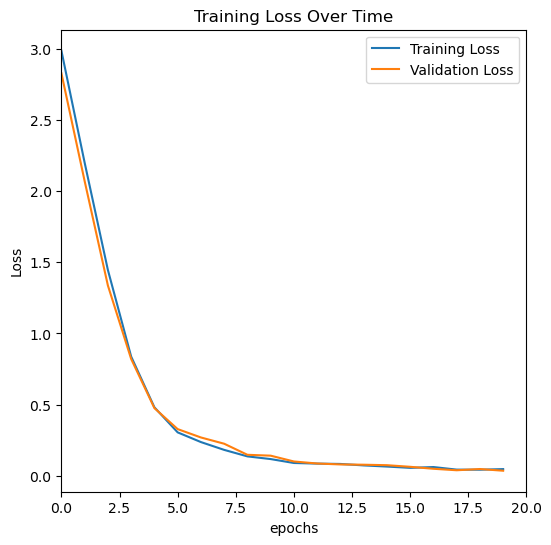

In [27]:
# Plot the loss graph
train_loss_values = []
step = 10
for i in range(1, len(loss_values)):
    if i % step == step - 1:
        train_loss_values.append(loss_values[i])
        
plt.figure(figsize=(6, 6)) # size of the plot
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
custom_x_range = (0, epochs)
plt.xlim(custom_x_range)
plt.show()

### TESTING
Test the trained network on test data

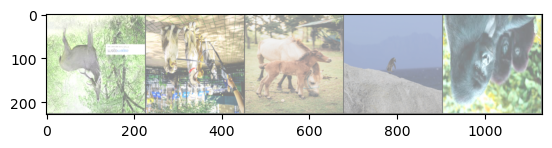

GroundTruth:  rusa-unicolor canis-lupus-familiaris equus-caballus aptenodytes-forsteri gorilla-gorilla
CPU times: user 722 ms, sys: 145 ms, total: 867 ms
Wall time: 23.4 s


In [28]:
%%time

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[0:5]))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(5)))

In [30]:
# Load the trained model
PATH = BASE_DIR / 'models/ac_large.pth'

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Run tests on a subset of test data

In [31]:
%%time
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}' for j in range(5)))

Predicted:  rusa-unicolor canis-lupus-familiaris equus-caballus aptenodytes-forsteri gorilla-gorilla
CPU times: user 474 ms, sys: 315 ms, total: 789 ms
Wall time: 298 ms


Run test on the entire test data

In [32]:
%%time
# Find the test loss
test_running_loss = 0.0
with torch.no_grad():
    for data in testloader:
        test_inputs, test_labels = data
        
        test_outputs = net(test_inputs)
        test_loss = criterion(test_outputs, test_labels)
        test_running_loss += test_loss.item()
print(f'Test Loss: {test_running_loss / len(testloader)}')

Test Loss: 0.04145690389072035
CPU times: user 2min 16s, sys: 47.6 s, total: 3min 4s
Wall time: 1min 38s


In [33]:
%%time
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        if inputs.size()[0] != batch_size:
            break
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Number of test images: {total}')
print(f'Number of correct predictions: {correct}')
print(f'Accuracy of the network on test images: {100 * correct // total} %')

Number of test images: 17280
Number of correct predictions: 17058
Accuracy of the network on test images: 98 %
CPU times: user 2min 17s, sys: 49 s, total: 3min 6s
Wall time: 1min 37s


Run test for each class

In [34]:
%%time
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
            
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * correct_count / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: acinonyx-jubatus is 98.8 %
Accuracy for class: agkistrodon-contortrix is 97.9 %
Accuracy for class: ailuropoda-melanoleuca is 99.3 %
Accuracy for class: ailurus-fulgens is 100.0 %
Accuracy for class: alces-alces is 100.0 %
Accuracy for class: anas-platyrhynchos is 97.7 %
Accuracy for class: apis-mellifera is 100.0 %
Accuracy for class: aptenodytes-forsteri is 99.3 %
Accuracy for class: aquila-chrysaetos is 98.4 %
Accuracy for class: ara-macao is 97.4 %
Accuracy for class: architeuthis-dux is 100.0 %
Accuracy for class: ardea-herodias is 100.0 %
Accuracy for class: balaenoptera-musculus is 100.0 %
Accuracy for class: betta-splendens is 100.0 %
Accuracy for class: bison-bison is 99.3 %
Accuracy for class: bos-gaurus is 100.0 %
Accuracy for class: bos-taurus is 99.2 %
Accuracy for class: bradypus-variegatus is 100.0 %
Accuracy for class: branta-canadensis is 100.0 %
Accuracy for class: canis-lupus is 99.2 %
Accuracy for class: canis-lupus-familiaris is 99.6 %
Accuracy 